This code will go through the process of running SMOTE, PCA, Decision Trees, and Logistical Regression

In [1]:
#%%
#import tools
from sklearn import datasets
import pandas as pd

In [2]:
#create dataframe
df = pd.read_csv("card_transdata - with sample ID.csv")
df = df.dropna(axis=1, how='any')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1,1,0,0,0
1,10.829943,0.175592,1.294219,1,0,0,0,0
2,5.091079,0.805153,0.427715,1,0,0,1,0
3,2.247564,5.600044,0.362663,1,1,0,1,0
4,44.190936,0.566486,2.222767,1,1,0,1,0


In [3]:
features = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']
X = df[features].values
y = df['fraud'].values

In [4]:
#standardize colums in X using StandardScaler
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
pd.DataFrame(data = X, columns = features).head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
0,0.477882,-0.182849,0.043491,0.366584,1.361576,-0.334458,-1.364425
1,-0.241607,-0.188094,-0.189300,0.366584,-0.734443,-0.334458,-1.364425
2,-0.329369,-0.163733,-0.498812,0.366584,-0.734443,-0.334458,0.732909
3,-0.372854,0.021806,-0.522048,0.366584,1.361576,-0.334458,0.732909
4,0.268572,-0.172968,0.142373,0.366584,1.361576,-0.334458,0.732909


In [5]:
#Initial observations. As you can see, certain variables seem to have an influence to fraud detection
print(df[df['fraud'] == 0].mean())
print(df[df['fraud'] == 1].mean())

distance_from_home                22.832976
distance_from_last_transaction     4.301391
ratio_to_median_purchase_price     1.423642
repeat_retailer                    0.881672
used_chip                          0.359402
used_pin_number                    0.109944
online_order                       0.622225
fraud                              0.000000
dtype: float64
distance_from_home                66.261876
distance_from_last_transaction    12.712185
ratio_to_median_purchase_price     6.006323
repeat_retailer                    0.880119
used_chip                          0.256399
used_pin_number                    0.003123
online_order                       0.946318
fraud                              1.000000
dtype: float64


Perform Smote

In [6]:
from sklearn.model_selection import train_test_split

y = df['fraud']
X = df[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price','repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']]
X = pd.get_dummies(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

X.shape

(1000000, 7)

In [7]:
from imblearn.over_sampling import SMOTE

# Previous original class distribution
print(y.value_counts()) 
X_resampled, y_resampled = SMOTE().fit_resample(X, y) 
# Preview synthetic sample class distribution
print('---------------------------------')
print(pd.Series(y_resampled).value_counts()) 

# Split resampled data into training and test sets
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_resampled, y_resampled, random_state=0)

0    912597
1     87403
Name: fraud, dtype: int64
---------------------------------
1    912597
0    912597
Name: fraud, dtype: int64


In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd  # Ensure pandas is imported

# Standardize columns in X using StandardScaler
X = StandardScaler().fit_transform(X)
pd.DataFrame(data = X, columns = features).head()

# Fit the PCA instance to the standardized data
pca_sm = PCA(n_components=2)
pincipalComponents_sm = pca_sm.fit_transform(X_resampled)

# Create a new dataset from the principal components
df_pca_sm = pd.DataFrame(data=pincipalComponents_sm, columns=['PC1', 'PC2'])
target_sm = pd.Series(df['fraud'], name='fraud')

# Concatenate the principal components with the target column
result_df_sm = pd.concat([df_pca_sm, target_sm], axis=1)
result_df_sm.head(5)

# Calculate the variance explained by principal components
print('Variance of each component:', pca_sm.explained_variance_ratio_)
print('\nTotal Variance Explained:', round(sum(pca_sm.explained_variance_ratio_)*100, 2))

Variance of each component: [0.88159989 0.11652309]

Total Variance Explained: 99.81


In [14]:
# Run the classifer on PCA'd data
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

X = result_df_sm[['PC1', 'PC2']]
y = result_df_sm['fraud']
model_sm = KNeighborsClassifier()
model_sm.fit(X_train_sm.values, y_train_sm.values)
Yhat_sm = model_sm.predict(X_test_sm.values)
acc_sm = metrics.accuracy_score(Yhat_sm, y_test_sm.values)
print('Accuracy:', acc_sm)
precision_sm = metrics.precision_score(Yhat_sm, y_test_sm.values)
print('Precision:', precision_sm)
recall_sm = metrics.recall_score(Yhat_sm, y_test_sm.values)
print('Recall:', recall_sm)
F1_sm = metrics.f1_score(Yhat_sm, y_test_sm.values)
print('F1 score:', F1_sm)


Accuracy: 0.9865263785368804
Precision: 0.9998551322686287
Recall: 0.9738536660452547
F1 score: 0.9866831286416705


Time to go into Logistical Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
smote = SMOTE (sampling_strategy = 'minority')

In [32]:
X_sm, y_sm = smote.fit_resample(X,y)

In [33]:
sm_logreg = LogisticRegression(fit_intercept=False,C=1e12, solver='liblinear')


# Fit the model
sm_logreg.fit(X_train_sm, y_train_sm)

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [39]:
y_hat_train_sm = sm_logreg.predict(X_train_sm)
y_hat_test_sm = sm_logreg.predict(X_test_sm)

In [40]:
# How many times was the classifier correct on the training set?
residuals_sm = np.abs(y_train_sm - y_hat_train_sm)
print(pd.Series(residuals_sm).value_counts())
print('------------------------------------')
print(pd.Series(residuals_sm).value_counts(normalize=True))

0    1210840
1     158055
Name: fraud, dtype: int64
------------------------------------
0    0.884538
1    0.115462
Name: fraud, dtype: float64


In [43]:
# Calculating metrics with sklearn
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
print('Training Precision: ', precision_score(y_train_sm, y_hat_train_sm))
print('Testing Precision: ', precision_score(y_test_sm, y_hat_test_sm))
print('\n\n')

print('Training Recall: ', recall_score(y_train_sm, y_hat_train_sm))
print('Testing Recall: ', recall_score(y_test_sm, y_hat_test_sm))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train_sm, y_hat_train_sm))
print('Testing Accuracy: ', accuracy_score(y_test_sm, y_hat_test_sm))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train_sm, y_hat_train_sm))
print('Testing F1-Score: ', f1_score(y_test_sm, y_hat_test_sm))

Training Precision:  0.852720123638331
Testing Precision:  0.8523110206773418



Training Recall:  0.929787106656951
Testing Recall:  0.9304503191480021



Training Accuracy:  0.8845382589606946
Testing Accuracy:  0.8847904553812302



Training F1-Score:  0.8895876135262595
Testing F1-Score:  0.8896682281435215


Decision Tree

In [44]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
# Instantiate the model
clf = DecisionTreeClassifier(criterion='entropy', max_depth= 3)

clf.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

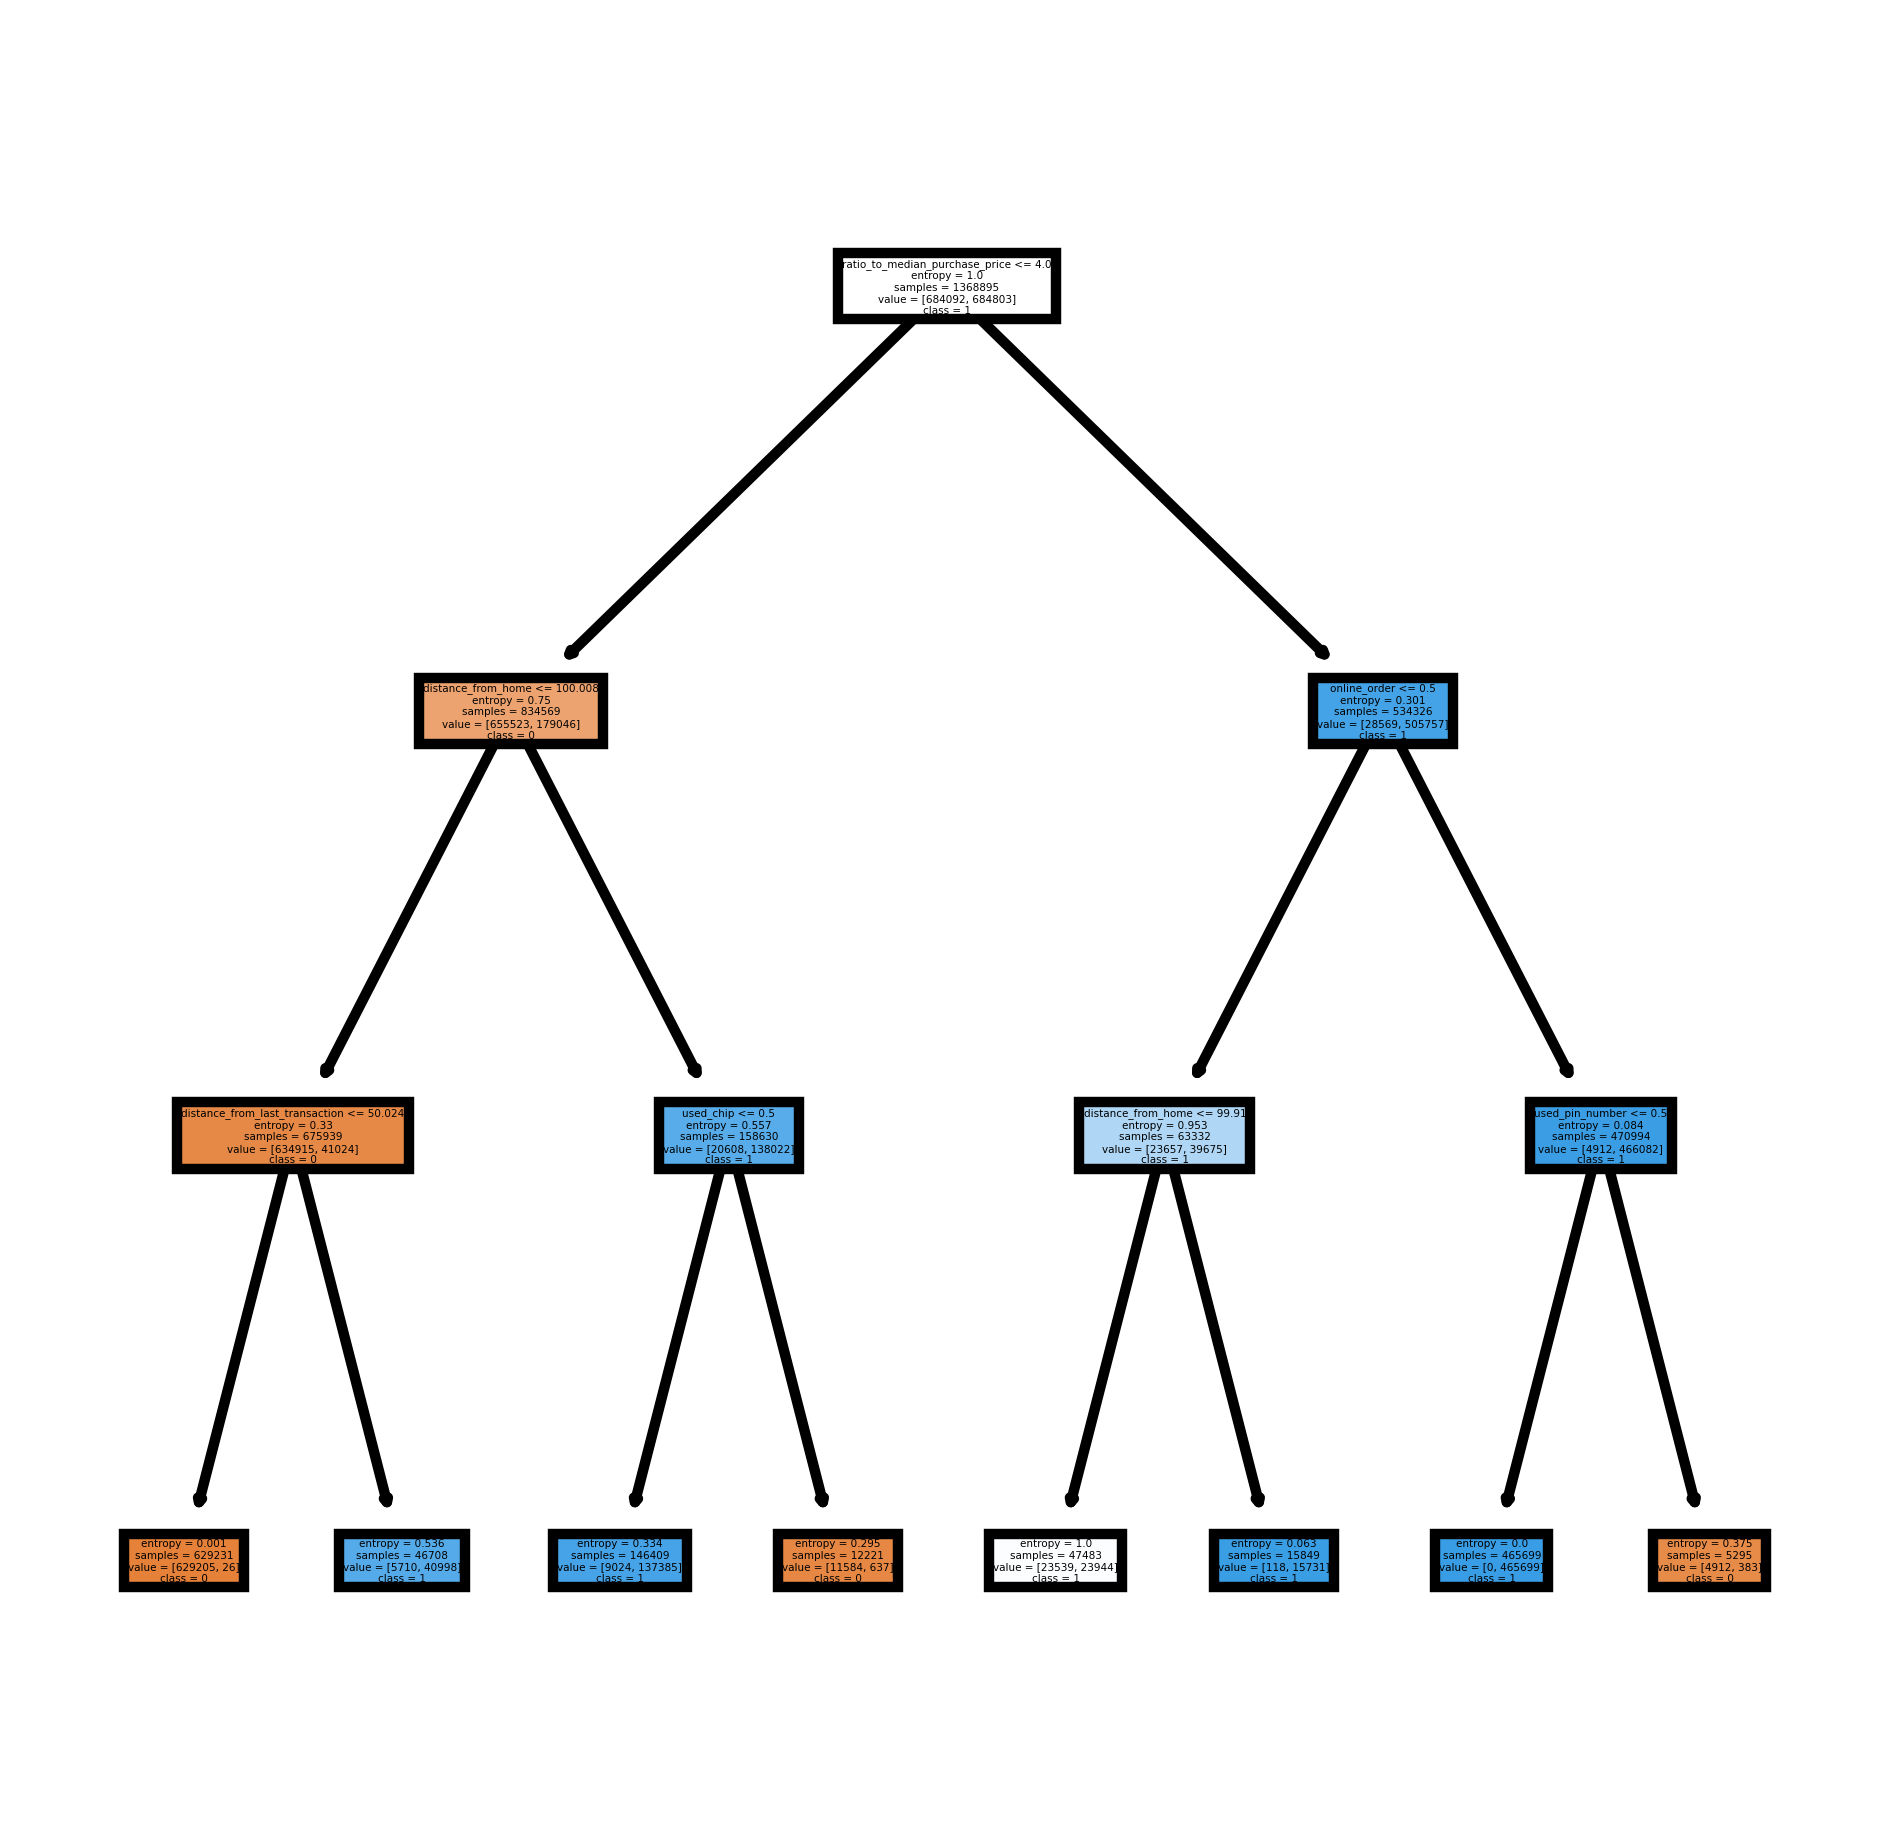

In [45]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=750)
tree.plot_tree(clf,
               feature_names = X_train_sm.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()

In [46]:
y_preds = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_preds))
from sklearn import metrics
recall = metrics.recall_score(y_test, y_preds)
print('Recall:', recall)

Accuracy:  0.948144
Recall: 0.9953514060845952


In [47]:
y_train_preds = clf.predict(X_train_sm)
print('Accuracy: ', accuracy_score(y_train_sm, y_train_preds))
from sklearn import metrics
recall = metrics.recall_score(y_train_sm, y_train_preds)
print('Recall:', recall)

Accuracy:  0.9711906318600039
Recall: 0.9984725534204727


In [48]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

print('Training Precision: ', precision_score(y_train_sm, y_train_preds))
print('Testing Precision: ', precision_score(y_test, y_preds))
print('\n\n')

print('Training Recall: ', recall_score(y_train_sm, y_train_preds))
print('Testing Recall: ', recall_score(y_test, y_preds))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train_sm, y_train_preds))
print('Testing Accuracy: ', accuracy_score(y_test, y_preds))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train_sm, y_train_preds))
print('Testing F1-Score: ', f1_score(y_test, y_preds))

Training Precision:  0.946837767327473
Testing Precision:  0.627040505668474



Training Recall:  0.9984725534204727
Testing Recall:  0.9953514060845952



Training Accuracy:  0.9711906318600039
Testing Accuracy:  0.948144



Training F1-Score:  0.9719698838125849
Testing F1-Score:  0.769389497651914
